In [66]:
# Questions
# Do we do HWE check on gangstr? check chr21:8993159
# Compute MI rate per locus, can filter on that?
# check low MI rate trios
# check sample whose trio we said was missing

In [67]:
%pylab inline

import os
import pandas as pd

tscc_path = "/projects/ps-gymreklab/helia/ensembl/experiments/mendelian_analysis/mend_chr21.tab"
local_path = "results/mend_chr21.tab"

# Use local file in /projects if on TSCC
try:
    os_info = os.uname()
    node_name = os_info.nodename
    if node_name[:4] == 'tscc':
        path = tscc_path
    else:
        path = local_path
except:
    path = local_path

data = pd.read_csv(path, sep="\t", 
                   names=["chrom","pos","motif","sample","method","gbs","MI","gtscore","alscore"])

Populating the interactive namespace from numpy and matplotlib


[0.9411677283325262, 0.9466533236776561, 0.9490900659636328, 0.9512095073154774, 0.9542441534506719]
[0.9768616744298121, 0.9805136031710704, 0.9823781621002353, 0.9842083294178324, 0.9864225105441969]
[0.9878701238668367, 0.9895765876852928, 0.9907351045545689, 0.9914965832874462, 0.9924957372505038]
[0.9863433601612311, 0.9879911566676716, 0.9893580258103989, 0.9906756299824058, 0.9920587800872896]
[0.9749212350346566, 0.9777034478755514, 0.9790108155165036, 0.9808073377968595, 0.9830015162251328]
[0.9646268488201423, 0.9655833088451367, 0.9669114593837868, 0.9689753560550426, 0.9721224014227019]
[0.9438732981383717, 0.9548538152128234, 0.9645103621796994, 0.9740748632715391, 0.9822253000923361]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]


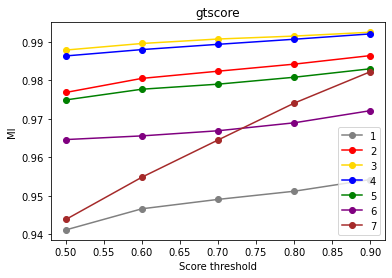

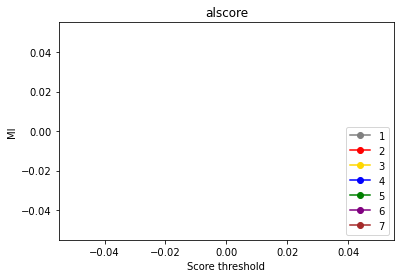

In [68]:
# MI vs. gtscore by period
percolors = ["gray","red","gold","blue","green","purple","brown"]

def PlotByScore(data, scorecol, percolors):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for period in range(1, 8):
        if period < 7:
            pdata = data[data["motif"].apply(len)==period].copy()
        else: pdata = data[data["motif"].apply(len)>=period].copy()
        mis = []
        ns = []
        thresh = np.arange(0.5, 1.0, 0.1)
        for t in thresh:
            mis.append(np.mean(pdata[pdata[scorecol]>=t]["MI"]))
            ns.append(pdata[pdata[scorecol]>=t].shape[0])
        ax.plot(thresh, mis, marker="o", color=percolors[period-1], label=period)
        print(mis)
    ax.set_xlabel("Score threshold")
    ax.set_ylabel("MI")
    ax.set_title(scorecol)
    ax.legend(loc="lower right")
    
PlotByScore(data, "gtscore", percolors)
PlotByScore(data, "alscore", percolors)

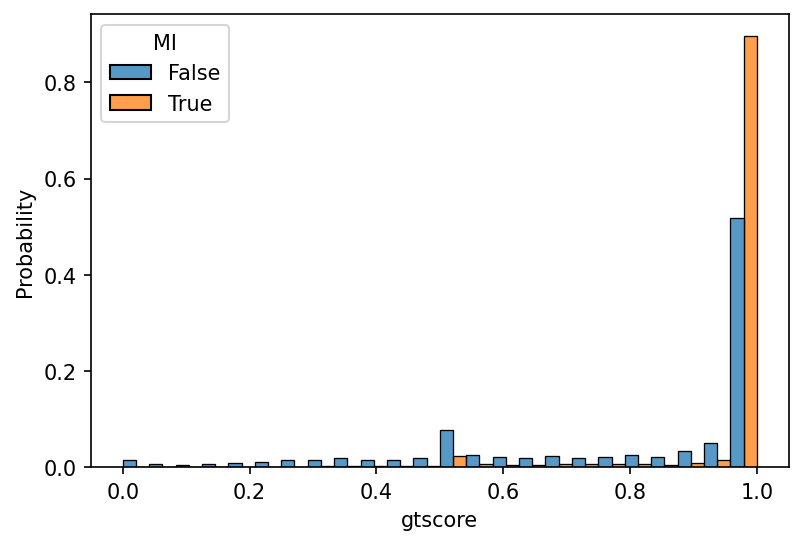

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=data, x='gtscore', hue='MI', common_norm=False, stat='probability', multiple='dodge')
plt.gcf().set_dpi(150)

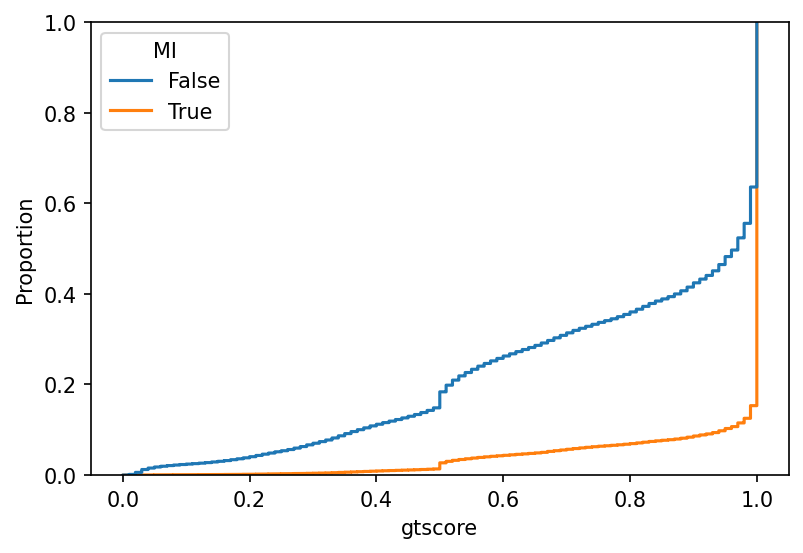

In [70]:
sns.ecdfplot(data=data, x='gtscore', hue='MI')
plt.gcf().set_dpi(150)

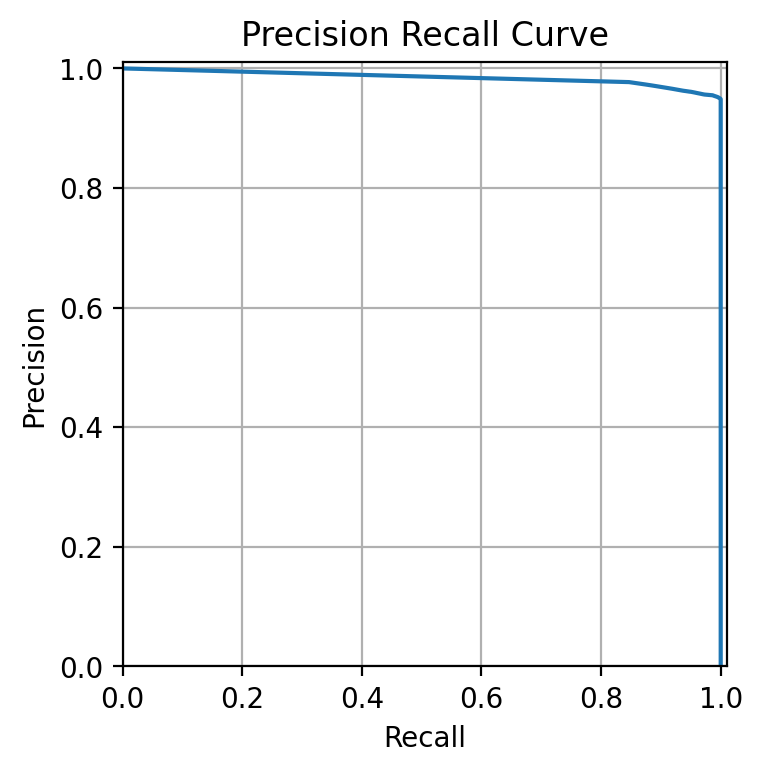

In [71]:
from sklearn import metrics

precision, recall, thresholds = metrics.precision_recall_curve(
	data.MI, data.gtscore
)
plt.plot([1] + recall.tolist(), [0] + precision.tolist())
plt.title("Precision Recall Curve")
plt.xlabel("Recall")
plt.xlim(0, 1.01)
plt.ylabel("Precision")
plt.ylim(0, 1.01)
plt.grid('both')
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_dpi(200)

In [72]:
# Now the same plots broken down by motif length

data['motif_length'] = data.motif.str.len()
# data.loc[data.motif_length >= 7, 'motif_length'] = 7
data.loc[data.motif_length >= 7, 'motif_length'] = '7+'
data.motif_length = data.motif_length.astype(str)
label_order = sorted(data.motif_length.unique())

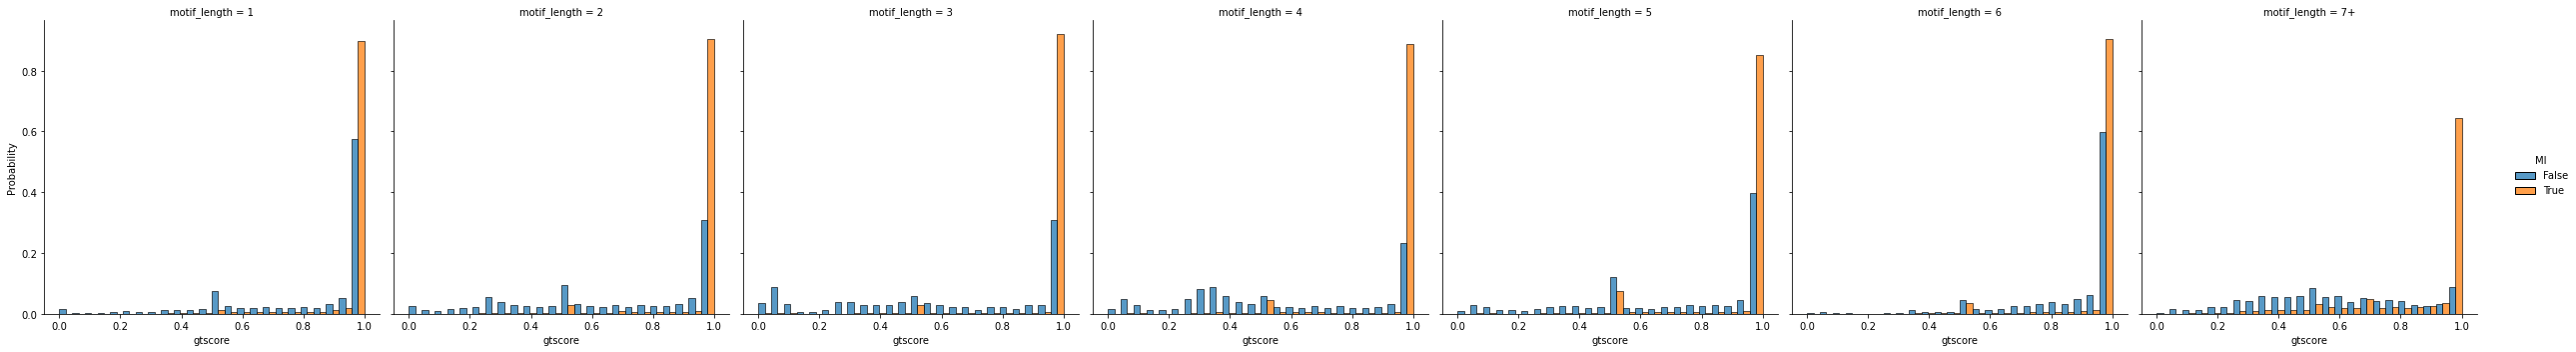

In [73]:
sns.displot(data=data, x='gtscore', hue='MI', col='motif_length', common_norm=False, stat='probability', multiple='dodge', col_order=label_order)
# plt.gcf().set_dpi(150)

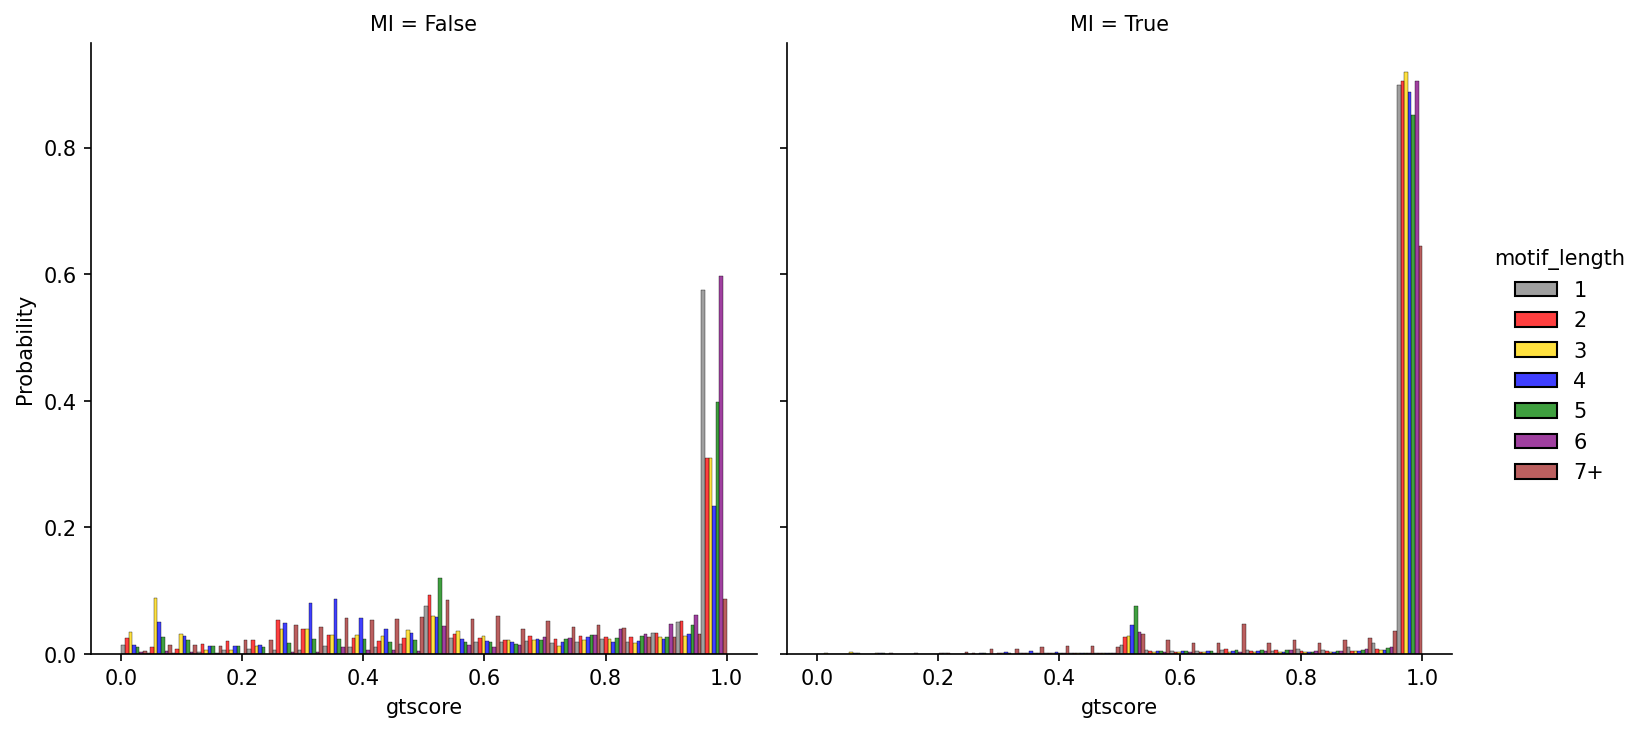

In [74]:
sns.displot(data=data, x='gtscore', hue='motif_length', col='MI', common_norm=False, stat='probability', multiple='dodge', palette=percolors, hue_order=label_order)
plt.gcf().set_dpi(150)

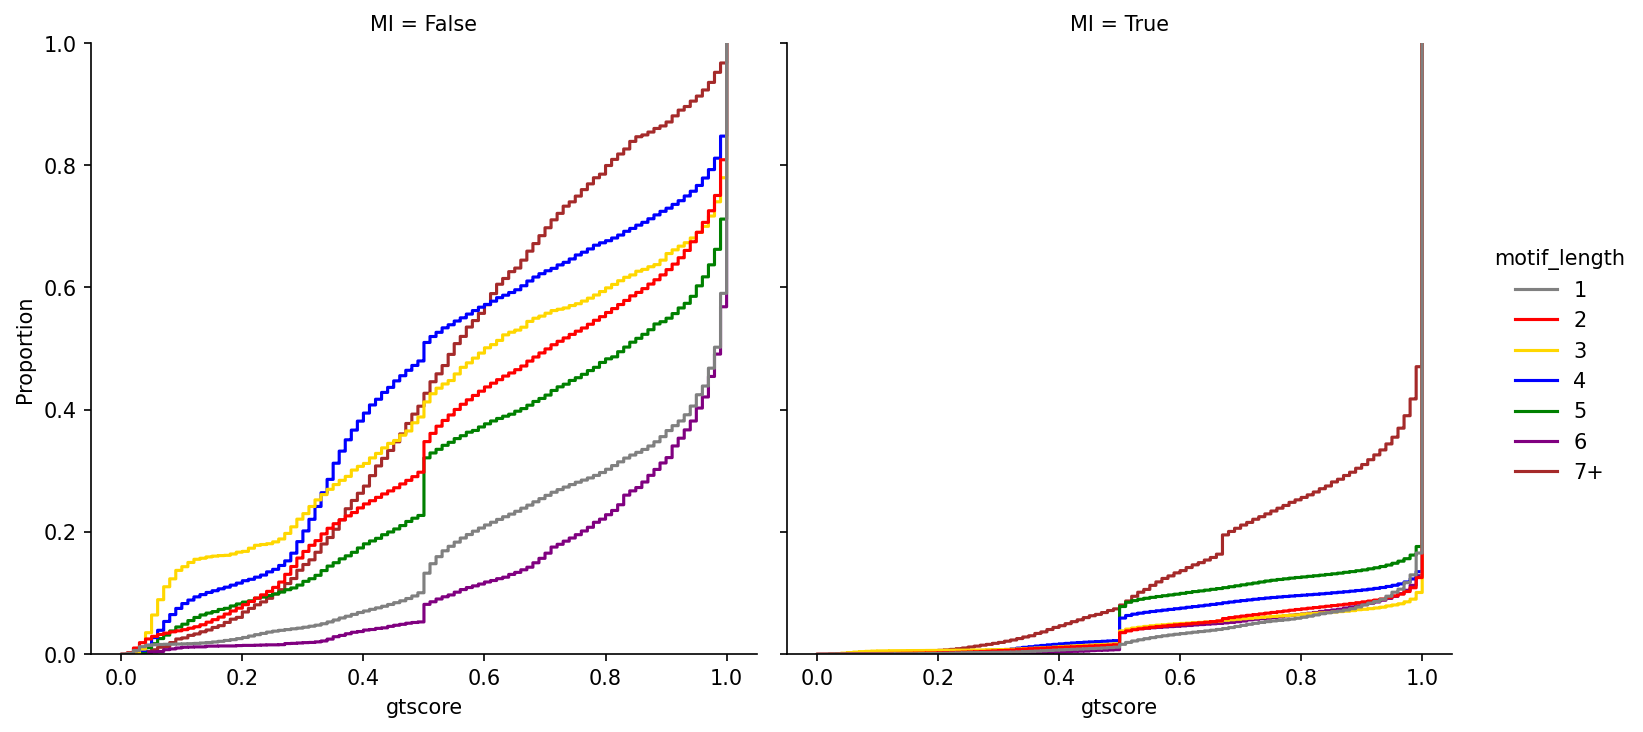

In [75]:
sns.displot(data=data, x='gtscore', col='MI', hue='motif_length', kind='ecdf', palette=percolors, hue_order=label_order)
plt.gcf().set_dpi(150)

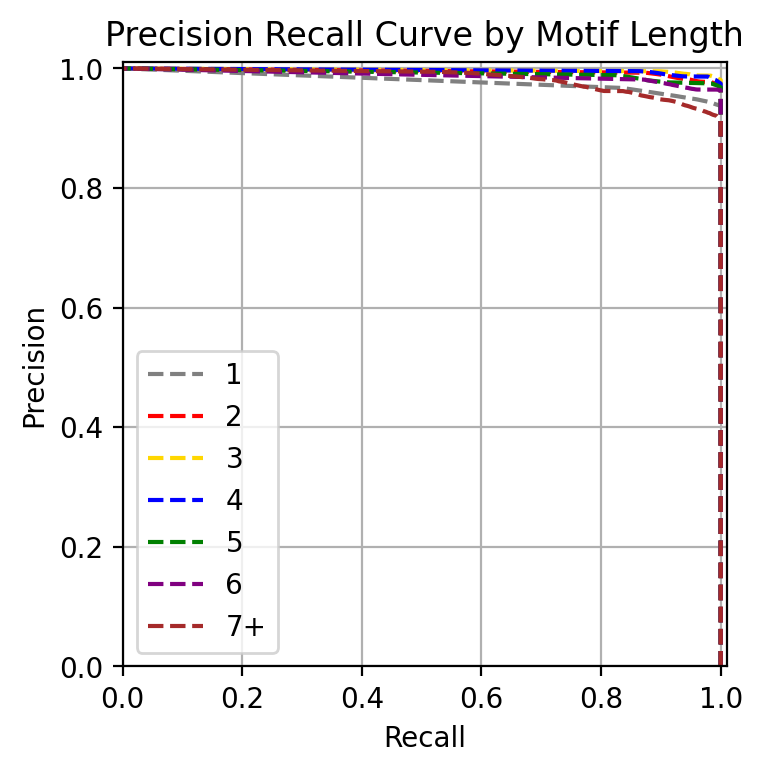

In [83]:
for i, motif_len in enumerate(label_order):
	data_w_motif_len = data[data.motif_length == motif_len]
	precision, recall, thresholds = metrics.precision_recall_curve(
		data_w_motif_len.MI, data_w_motif_len.gtscore
	)
	plt.plot(
		[1] + recall.tolist(), 
		[0] + precision.tolist(),
		'--',
		label=motif_len,
		color=percolors[i],
	)

plt.title("Precision Recall Curve by Motif Length")
plt.xlabel("Recall")
plt.xlim(0, 1.01)
plt.ylabel("Precision")
plt.ylim(0, 1.01)
plt.grid('both')
plt.gca().set_aspect('equal', adjustable='box')
plt.gcf().set_dpi(200)
plt.legend(loc='lower left')

In [77]:
# by method (advntr|eh|hipstr|gangstr)
data.groupby(["method"], as_index=False).agg({"MI": np.mean, "sample": len}).sort_values(["MI"], ascending=False)

,method,MI,sample
5,0|1|1|0,0.990286,64343
6,0|1|1|1,0.987952,129480
3,0|1|0|0,0.983026,26983
4,0|1|0|1,0.982184,10440
10,1|1|0|1,0.976705,601
1,0|0|1|0,0.976560,1566877
7,1|0|0|0,0.942627,2109
2,0|0|1|1,0.938088,2492575
8,1|0|0|1,0.895623,1188
0,0|0|0|1,0.886871,449029


,sample,MI,pos
276,HG02683,0.926375,7674
293,HG02776,0.934737,7646
462,NA10843,0.935113,7567
152,HG01683,0.935889,7643
486,NA12739,0.936510,7513


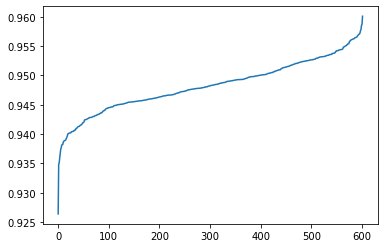

In [78]:
# by sample. check by ancestry
bysample = data.groupby("sample", as_index=False).agg({"MI": np.mean, "pos": len}).sort_values("MI")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(bysample.shape[0]), bysample["MI"])
bysample.head()

In [79]:
# (advntr|eh|hipstr|gangstr)
bypos = data.groupby(["method","pos"], as_index=False).agg({"MI": np.mean, "sample": len})

In [80]:
# Bad gangstr-only calls
bypos[(bypos["method"]=="0|0|0|1") & (bypos["sample"]>10)].sort_values(["MI","sample"])

,method,pos,MI,sample
1538,0|0|0|1,37677771,0.312253,253
1847,0|0|0|1,41757999,0.342246,187
1346,0|0|0|1,35806576,0.363636,11
364,0|0|0|1,20460618,0.399351,308
1537,0|0|0|1,37655180,0.408060,397
...,...,...,...,...
326,0|0|0|1,19808112,1.000000,602
671,0|0|0|1,25577031,1.000000,602
1072,0|0|0|1,32134480,1.000000,602
1129,0|0|0|1,32968745,1.000000,602


In [81]:
# Bad advntr-only calls
bypos[(bypos["method"]=="1|0|0|0") & (bypos["sample"]>10)].sort_values(["MI","sample"])

,method,pos,MI,sample
16321,1|0|0|0,31671897,0.585366,41
16328,1|0|0|0,43719168,0.650794,63
16320,1|0|0|0,30880126,0.880000,25
16322,1|0|0|0,32393012,0.889241,316
16325,1|0|0|0,42024343,0.902655,113
16323,1|0|0|0,34614946,0.937500,16
16324,1|0|0|0,41316674,0.945205,219
16326,1|0|0|0,42311309,0.960168,477
16327,1|0|0|0,42346245,1.000000,225
16331,1|0|0|0,45504503,1.000000,602
